# Intro to RNNs
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/05_01_intro_to_RNNs.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/05_01_intro_to_RNNs.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-alpha0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
# Common imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## RNN Step-by-Step
A recurrent neural network (RNN) is an artificial neural network that maintains an internal state (memory)
as it processes items in a sequence. RNNs are most often applied to sequence data such as text
(sequences of characters; sequences of words) or time series (e.g., stock prices, weather data, neurophysiology).
RNNs can provide an output at each step of the sequence to predict different sequences (e.g., text translation) or
the next item in the same sequence (e.g., assistive typing, stock prediction, prosthetic control).
The loss does not back-propagate to update weights until the sequence is complete. RNNs can also be configured
to produce a single output at the end of a sequence (e.g., classify a tweet sentiment, decode categorical intention).

We will create our own RNN step-by-step. We will train it using toy data that we generate.

### Generate data
X is a multi-channel time series and Y is a different multi-channel time series
constructed from a linear combination of a delayed version of X.

In [3]:
PEAK_FREQS = [10, 22, 75]
FS = 1000.0
DURATION = 5.0
DELAY = 0.01
N_OUT = 2

n_samples = int(DURATION * FS)
delay_samples = int(DELAY * FS)
t_vec = np.arange(n_samples + delay_samples) / FS

X = np.zeros((n_samples + delay_samples, len(PEAK_FREQS)), dtype=np.float32)
for chan_ix, pf in enumerate(PEAK_FREQS):
    X[:, chan_ix] = (1 / (chan_ix + 1) ) * np.sin(t_vec * 2 * np.pi * pf)

# Create mixing matrix that mixes inputs into outputs
W = 2 * np.random.rand(N_OUT, len(PEAK_FREQS)) - 1
# W = W / np.sum(W, axis=1, keepdims=True)

b = np.random.rand(N_OUT) - 0.5

Y = W @ X[:-delay_samples, :].T + b[:, None]
Y = Y.T
X = X[delay_samples:, :]
t_vec = t_vec[delay_samples:]

X += 0.05*np.random.rand(*X.shape)
Y += 0.05*np.random.rand(*Y.shape)

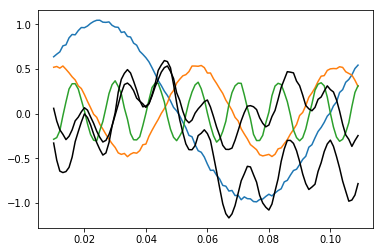

In [4]:
plt.plot(t_vec[:100], X[:100, :])
plt.plot(t_vec[:100], Y[:100, :], 'k')
plt.show()

### Define forward pass and loss
We aren't actually going to run this next cell.
This is just to give you an indication of what the forward pass looks like.

In [7]:
activation_fn = lambda x: x
# activation_fn = np.tanh
state_t = np.zeros((N_OUT,))
_W = np.random.random((N_OUT, X.shape[1]))  # Mixes input with output
_U = np.random.random((N_OUT, N_OUT))       # Mixes old state with output
_b = np.random.random((N_OUT,))             # Bias term
successive_outputs = []
for x_t in X:
    y_t = activation_fn(np.dot(_W, x_t) + np.dot(_U, state_t) + _b)
    successive_outputs.append(y_t)
    state_t = y_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)
loss = np.mean( (Y - final_output_sequence)**2 ) 

## RNN in Tensorflow
[Tutorial](https://www.tensorflow.org/tutorials/sequences/text_generation) (text generation w/ eager)

### Prepare data for Tensorflow
In the tutorial linked above, the `batch` transformation is used to convert a continuous sequence into
many sequences, then the batch transform is used AGAIN to get batches of sequences.

In [5]:
SEQ_LENGTH = 200
BATCH_SIZE = 2
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.batch(SEQ_LENGTH, drop_remainder=True)  # Continuous to segmented sequences
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)  # Segmented sequences to batches of seg. seq.

### Define RNN model in Tensorflow

In [6]:
inputs = tf.keras.layers.Input(shape=(SEQ_LENGTH, X.shape[-1]))
outputs = tf.keras.layers.SimpleRNN(N_OUT, return_sequences=True, activation='linear')(inputs)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 3)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200, 2)            12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Just to save us some training time, let's cheat and init the model with good weights
old_init_weights = model.layers[-1].get_weights()
model.layers[-1].set_weights([W.T, old_init_weights[1], b])

In [15]:
EPOCHS = 50
history = model.fit(x=dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
12/12 [==============================] - 4s 311ms/step - loss: 0.3597
Epoch 2/50
12/12 [==============================] - 2s 170ms/step - loss: 0.3125
Epoch 3/50
12/12 [==============================] - 2s 175ms/step - loss: 0.2899
Epoch 4/50
12/12 [==============================] - 2s 172ms/step - loss: 0.2709
Epoch 5/50
12/12 [==============================] - 2s 179ms/step - loss: 0.2534
Epoch 6/50
12/12 [==============================] - 2s 171ms/step - loss: 0.2371
Epoch 7/50
12/12 [==============================] - 2s 169ms/step - loss: 0.2218
Epoch 8/50
12/12 [==============================] - 2s 171ms/step - loss: 0.2077
Epoch 9/50
12/12 [==============================] - 2s 181ms/step - loss: 0.1948
Epoch 10/50
12/12 [==============================] - 2s 168ms/step - loss: 0.1832
Epoch 11/50
12/12 [==============================] - 2s 175ms/step - loss: 0.1728
Epoch 12/50
12/12 [==============================] - 2s 178ms/step - loss: 0.1636
Epoch 13/50
12/12 [======

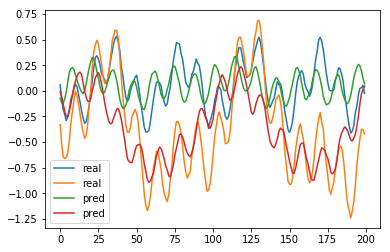

In [16]:
_Y1 = model.predict(X[:SEQ_LENGTH, :][None, :, :])
plt.plot(Y[:SEQ_LENGTH, :], label='real')
plt.plot(_Y1[0], label='pred')
plt.legend()
plt.show()

[[ 0.02653957 -0.5080045  -0.64241511]
 [ 0.50906611 -0.57618861 -0.93858413]]
[[ 0.26748428 -0.08929905 -0.10295779]
 [ 0.33698496  0.00830364 -0.5171865 ]]
[ 0.03795462 -0.37762544] [-0.22375248 -0.37587324]


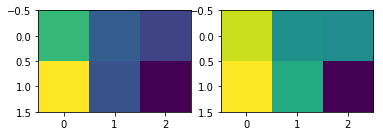

In [17]:
_W, _U, _b = model.layers[-1].get_weights()

print(W)
print(_W.T)
print(b, _b)

plt.subplot(1, 2, 1)
plt.imshow(W)
plt.subplot(1, 2, 2)
plt.imshow(_W.T)
plt.show()
